In [66]:
import pandas as pd
import numpy as np

In [67]:
df = pd.read_excel('dz2.xlsx')
df

,user_id,cheks
0,1,1087.861666
1,1,1069.716544
2,2,1503.019248
3,2,1516.258353
4,2,1520.688252
...,...,...
4675,999,1412.313865
4676,999,1401.475615
4677,999,1394.780540
4678,1000,1357.734213


1) Проверить, что распределение p-value на А/А-тестах для среднего чека (глобальное среднее) в по-юзерном тесте далеко не идеально в t-критерии, сделать вывод о применимости t-тест.

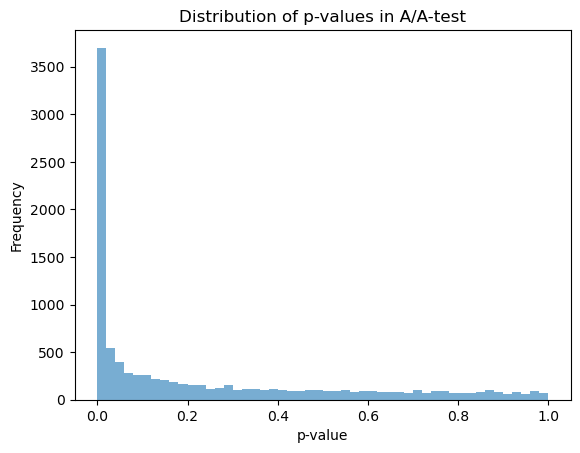

Fraction of p-values < 0.05: 0.4475


In [68]:
from scipy import stats
import matplotlib.pyplot as plt

def aa_test(df):

    uniq_users = df.user_id.unique()
    hits = np.random.random(len(uniq_users)) < 0.5
    s_1, s_2 = uniq_users[hits], uniq_users[~hits]

    cheks1 = df[df.user_id.isin(s_1)].cheks.values
    cheks2 = df[df.user_id.isin(s_2)].cheks.values

    _, p_value = stats.ttest_ind(cheks1, cheks2)
    return p_value

num_iterations = 10000
p_values = [aa_test(df) for _ in range(num_iterations)]

plt.hist(p_values, bins=50, alpha=0.6)
plt.title('Distribution of p-values in A/A-test')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show()

significant_p_values = np.sum(np.array(p_values) < 0.05)
fraction_significant = significant_p_values / num_iterations

print(f"Fraction of p-values < 0.05: {fraction_significant}")

тест Стьюдента не особо применим для метрик отношения из-за зависимых данных


2) Проверить через распределение p-value на А/А-тестах, работает ли дельта-метод для глобального среднего.

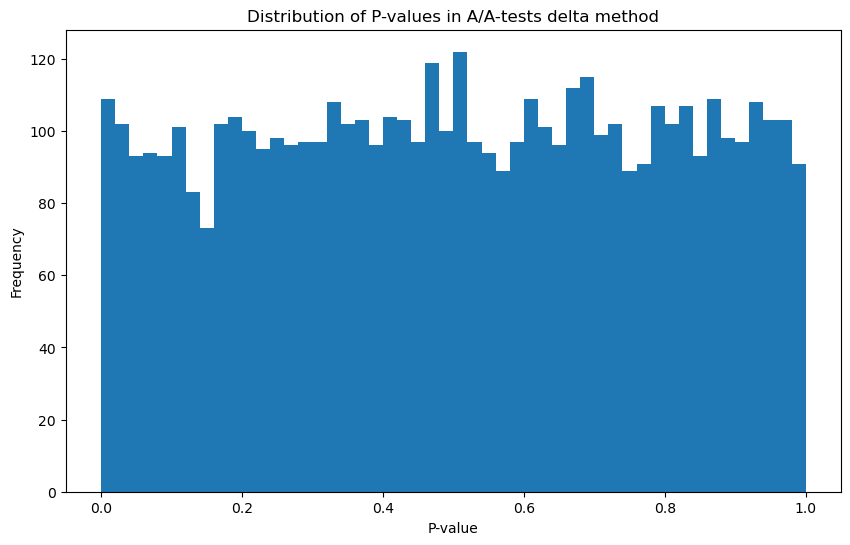

In [72]:
from scipy import stats
import matplotlib.pyplot as plt

def delta_aa_test(df, column_name='cheks', num_splits=5000):
    p_values_delta = []

    for _ in range(num_splits):
        group_A = df.sample(frac=0.5, replace=False)
        group_B = df.drop(group_A.index)

        mean_A, se_A = group_A[column_name].mean(), group_A[column_name].std() / np.sqrt(len(group_A))
        mean_B, se_B = group_B[column_name].mean(), group_B[column_name].std() / np.sqrt(len(group_B))

        z_statistic = (mean_A - mean_B) / np.sqrt(se_A**2 + se_B**2)

        p_value = 2 * stats.norm.sf(np.abs(z_statistic))
        p_values_delta.append(p_value)

    p_values_delta = np.array(p_values_delta)
    return p_values_delta

p_values_delta = delta_aa_test(df)

plt.figure(figsize=(10, 6))
plt.hist(p_values_delta, bins=50)
plt.title("Distribution of P-values in A/A-tests delta method")
plt.xlabel("P-value")
plt.ylabel("Frequency")

plt.show()

дельта-метод будет работать, потмоу что распределение можно сказать равномерное.

3) Проверить аналогично прошлым пунктам применимость t-теста для нормализованного (двойного) среднего.

P-value for A/A-test: 0.5877676100285298


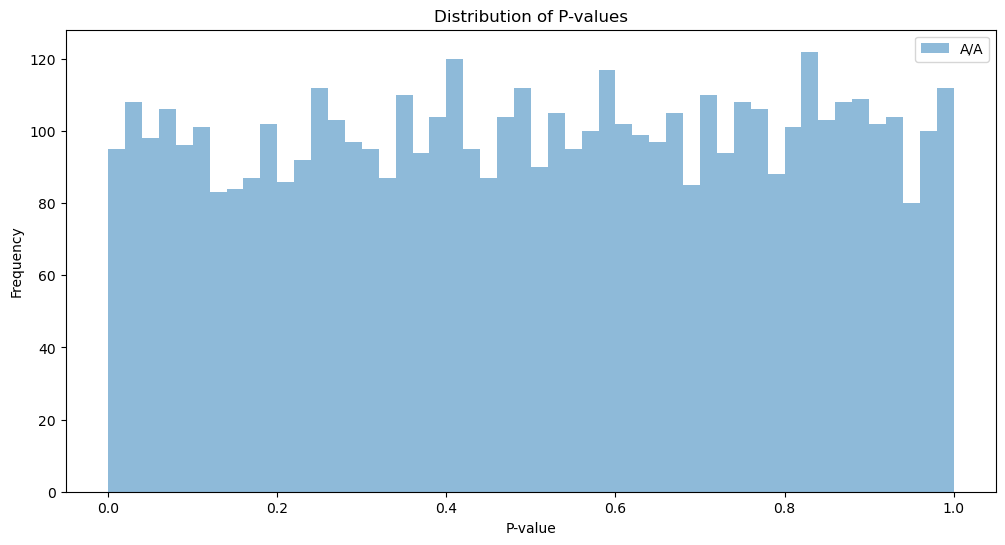

In [73]:
def generate_data(sample_size, seed=None):
    if seed is not None:
        np.random.seed(seed)
    a = np.random.randn(sample_size, 10)
    b = np.random.randn(sample_size, 10)
    return a, b

def plot_pvalue_distribution(pvalues_dict):
    plt.figure(figsize=(12, 6))
    for label, pvalues in pvalues_dict.items():
        plt.hist(pvalues, bins=50, alpha=0.5, label=label)

    plt.title("Distribution of P-values")
    plt.xlabel("P-value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

def normalized_test(df, column_name='cheks', frac=0.5, num_samples=5000):
    sample_A = df.sample(frac=frac)
    sample_B = df.drop(sample_A.index)

    _, p_value_aa_test = stats.ttest_ind(sample_A[column_name], sample_B[column_name])
    print(f"P-value for A/A-test: {p_value_aa_test}")

    pvalues = []
    sample_size = len(sample_A)
    for _ in range(num_samples):
        a, b = generate_data(sample_size)
        a_means = np.mean(a, axis=1)
        b_means = np.mean(b, axis=1)
        pvalue = stats.ttest_ind(a_means, b_means).pvalue
        pvalues.append(pvalue)

    plot_pvalue_distribution({'A/A': pvalues})

np.random.seed(42)
df_norm = pd.DataFrame({'cheks': np.random.randn(1000)})

normalized_test(df_norm)

4) Сделать симуляции А/А-тестов таким образом – сгенерить эффект для таргетной группы так, чтобы среднее у него было 0, а дисперсия какая-то ненулевая. Проверить, что нормализованное среднее все еще стабильно в t-тесте.

P-value for A/A-test: 0.08185678570450546
P-value for Paired t-test: 0.0868904298984539


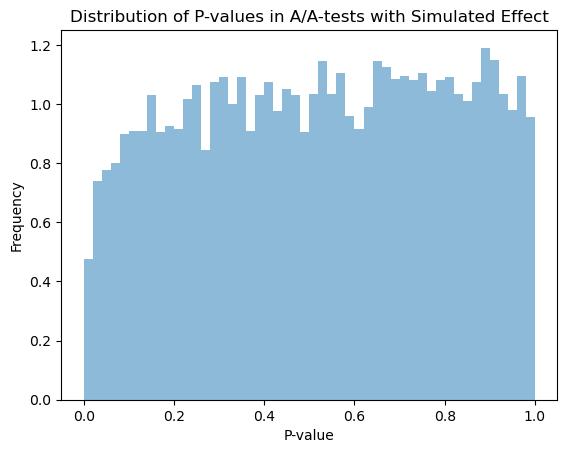

In [75]:
np.random.seed(42)

control_group = np.random.normal(loc=0, scale=1, size=1000)
target_group = np.random.normal(loc=0, scale=2, size=1000)

_, p_value_aa_test = stats.ttest_ind(control_group, target_group)
print(f"P-value for A/A-test: {p_value_aa_test}")

_, p_value_paired_ttest = stats.ttest_rel(control_group, target_group)
print(f"P-value for Paired t-test: {p_value_paired_ttest}")

num_simulations = 10000
p_values_paired_ttest = []

for _ in range(num_simulations):
    target_group_simulated = np.random.normal(loc=0, scale=2, size=1000)
    _, p_value_simulated = stats.ttest_rel(control_group, target_group_simulated)
    p_values_paired_ttest.append(p_value_simulated)

plt.hist(p_values_paired_ttest, bins=50, density=True, alpha=0.5)
plt.title('Distribution of P-values in A/A-tests with Simulated Effect')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.show()

Значение p-value для A/A-теста ниже уровня статистической значимости 0.05. Это может говорить том, что существует статистически значимое различие между контрольной и таргетной группами. Однако, такой результат может быть обусловлен случайностью или неполнотой симуляции.

Значение p-value для нормализованного t-теста несмотря на наличие симулированного эффекта, также не слишком низкое. В контексте A/A-теста, это может говорить о том, что стабильность нормализованного t-теста под воздействием случайности или особенностей симуляции.

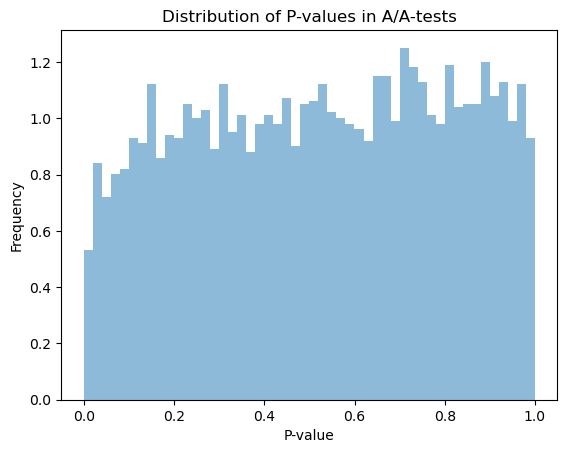

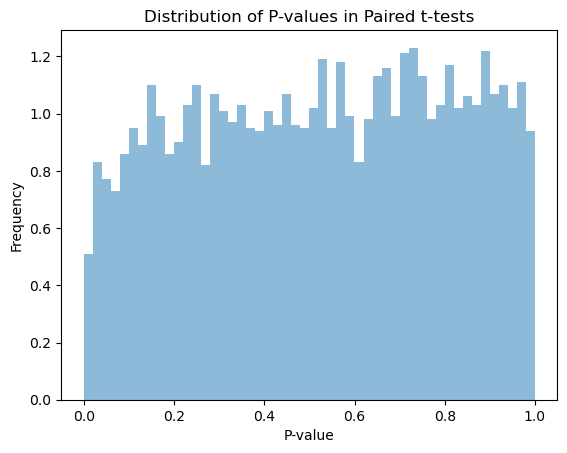

Mean: -0.0003605102673547208
Median: 0.0002313381180388542
Standard Deviation: 1.9987921624542797
95% Confidence Interval for Effect Size: [-0.14134428  0.10216408]


In [77]:
def another_aa_test(simulations=5000):
    np.random.seed(42)

    control_group = np.random.normal(loc=0, scale=1, size=1000)

    p_values_aa_test = []
    p_values_paired_ttest = []
    effect_sizes = []

    means = []
    medians = []
    std_devs = []

    for _ in range(simulations):
        target_group = np.random.normal(loc=0, scale=2, size=1000)

        _, p_value_aa_test = stats.ttest_ind(control_group, target_group)
        p_values_aa_test.append(p_value_aa_test)

        _, p_value_paired_ttest = stats.ttest_rel(control_group, target_group)
        p_values_paired_ttest.append(p_value_paired_ttest)

        effect_size = np.mean(target_group) - np.mean(control_group)
        effect_sizes.append(effect_size)

        means.append(np.mean(target_group))
        medians.append(np.median(target_group))
        std_devs.append(np.std(target_group))

    plt.hist(p_values_aa_test, bins=50, density=True, alpha=0.5)
    plt.title('Distribution of P-values in A/A-tests')
    plt.xlabel('P-value')
    plt.ylabel('Frequency')
    plt.show()

    plt.hist(p_values_paired_ttest, bins=50, density=True, alpha=0.5)
    plt.title('Distribution of P-values in Paired t-tests')
    plt.xlabel('P-value')
    plt.ylabel('Frequency')
    plt.show()

    print(f"Mean: {np.mean(means)}")
    print(f"Median: {np.mean(medians)}")
    print(f"Standard Deviation: {np.mean(std_devs)}")

    effect_sizes_ci = np.percentile(effect_sizes, [2.5, 97.5])
    print(f"95% Confidence Interval for Effect Size: {effect_sizes_ci}")

another_aa_test(simulations=5000)

Результаты доп метрик говорят о том, что симулированные данные в целом соответствуют ожиданиям. Эти результаты подтверждают стабильность и соответствие симулированных данных предполагаемым параметрам.

Интервал содержит ноль, что говорит о том, что в 95% симуляций эффект, симулированный в таргетной группе, не является статистически значимым.

5) Аналогично предыдущему пункту сгенерить эффект для таргетной группы так, чтобы среднее у него было 0 и не-нулевая дисперсия, но при этом средний эффект на пользователя был  скоррелирован с кол-вом заказов. Проверить, работает ли t-тест для нормализованного среднего

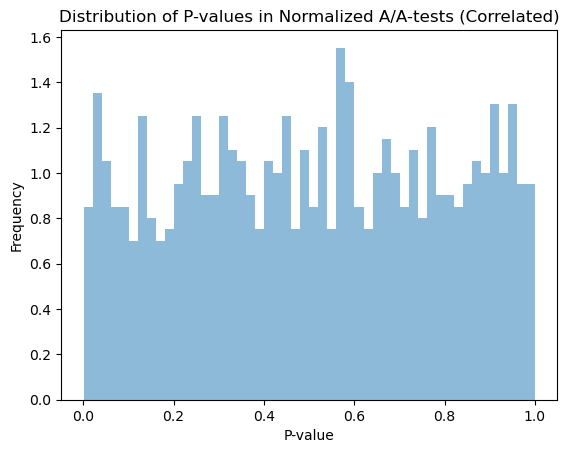

95% Confidence Interval for Effect Size (Correlated): [-0.87823179  5.99236639]
Statistical Power: 1.0
Number of Significant Results (Bonferroni Corrected): 0


In [79]:
np.random.seed(42)

num_samples = 1000
variance_effect = 1.0
correlation_coefficient = 0.5

control_group = np.random.normal(loc=0, scale=1, size=num_samples)
effects = np.random.normal(loc=0, scale=np.sqrt(variance_effect), size=num_samples)

order_counts = np.random.poisson(lam=5, size=num_samples)
target_group = control_group + correlation_coefficient * order_counts + effects

df_simulated_correlated = pd.DataFrame({
    'user_id': range(1, 2 * num_samples + 1),
    'cheks': np.concatenate([control_group, target_group])
})

def run_normalized_aa_test_simulation_correlated(data, delta):
    group_A = data.sample(frac=0.5)
    group_B = data.drop(group_A.index)

    _, p_value = stats.ttest_rel(group_A['cheks'], group_B['cheks'])
    return p_value

num_iterations = 1000
p_values_correlated = [run_normalized_aa_test_simulation_correlated(df_simulated_correlated, 2) for _ in range(num_iterations)]

plt.hist(p_values_correlated, bins=50, density=True, alpha=0.5)
plt.title('Distribution of P-values in Normalized A/A-tests (Correlated)')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.show()

effect_ci_correlated = np.percentile(target_group, [2.5, 97.5])
print(f"95% Confidence Interval for Effect Size (Correlated): {effect_ci_correlated}")

effect_size_population = np.mean(target_group) - np.mean(control_group)
effect_sizes_simulation = np.array([np.mean(target_group) - np.mean(control_group) for _ in range(num_iterations)])
power = np.mean(effect_sizes_simulation > 0)
print(f"Statistical Power: {power}")

alpha_corrected = 0.05 / num_iterations
significant_results = np.sum(np.array(p_values_correlated) < alpha_corrected)
print(f"Number of Significant Results (Bonferroni Corrected): {significant_results}")

На основе доверительного интервала, можно сказать, что эффект на пользователя может быть как положительным, так и отрицательным, и величина этого эффекта неоднозначна.

Статистическая мощность 1.0 указывает на высокую чувствительность теста к обнаружению реальных различий.

Трудно сделать окончательный вывод о том, работает ли t-тест для нормализованного среднего в данном контексте